In [1]:
from typing import Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from dateutil.relativedelta import relativedelta
from scipy.stats import gaussian_kde

## ETAPA 1 : EDA

In [2]:
# Descargamos el dataframe con información de los municipios
df_muni = pd.read_excel("base_municipios.xlsx")
df_muni.head(5)

,codigo_municipio,municipio,codigo_region,nombre_region,codigo_area,nombre_area,conurbano_interior,seccion_electoral,superficie(km2),intendente,partido_politico_actual,poblacion_censo_2010,poblacion_censo_2022
0,1,Adolfo Alsina,3,NOROESTE,3,NOROESTE,Interior,6,5881.6,Javier Andrés,Juntos por el Cambio,17072.0,17552
1,51,Adolfo Gonzáles Cháves,9,SURESTE,8,CENTRO SUR,Interior,6,3788.7,Miriam Lucía Gomez,Juntos por el Cambio,12047.0,12914
2,2,Alberti,2,NORTE,5,CENTRO NORTE,Interior,4,1122.6,Germán Lago,Unión por la Patria,10654.0,12982
3,3,Alte. Brown,5,RMBA,15,RMBA SUR,Conurbano,3,129.3,Mariano Cascallares,Unión por la Patria,552902.0,584827
4,10,Arrecifes,2,NORTE,2,NORTE,Interior,2,1243.8,Juan Fernando Bouvier,Juntos por el Cambio,29044.0,32215


In [3]:
df_muni.columns

Index(['codigo_municipio', 'municipio', 'codigo_region', 'nombre_region',
       'codigo_area', 'nombre_area', 'conurbano_interior', 'seccion_electoral',
       'superficie(km2)', 'intendente', 'partido_politico_actual',
       'poblacion_censo_2010', 'poblacion_censo_2022'],
      dtype='object')

In [4]:
# Descargamos el dataframe con información de los inscriptos al programa
df_insc = pd.read_excel("ficha_inscriptos.xlsx")
df_insc.head(5)

,id,activo,state,criterios_priorizacion,created_at,updated_at,es_duplicado,fecha_solicitud,estado_priorizacion,criterios_aceptacion,...,q_sorteo,etapa_inscripcion,fuente_financiamiento,nro_documentacion_ee,nro_adjudicacion_ee,nro_resolucion_adjudicacion,etapa_cupo_procesamiento,etapa_cupo_liquidacion,external_service_state,nro_respuesta
0,207513,False,desestimado,NaN,2022-10-11 15:32:47,2022-11-04 14:46:50,True,NaN,0,NaN,...,0,2,NaN,NaN,NaN,NaN,0.0,0,0,503280
1,207649,False,desestimado,NaN,2022-10-11 15:32:51,2022-11-04 14:46:50,True,NaN,0,NaN,...,0,2,NaN,NaN,NaN,NaN,0.0,0,0,501340
2,208175,False,desestimado,NaN,2022-10-11 15:33:07,2022-11-04 14:46:50,True,NaN,0,NaN,...,0,2,NaN,NaN,NaN,NaN,0.0,0,0,496204
3,5372,True,no_admisible,NaN,2022-08-31 16:28:43,2023-07-19 10:28:14,False,NaN,0,"--- '[{""valor"":true,""clave"":""Empleado o funcio...",...,0,1,NaN,NaN,NaN,NaN,0.0,0,0,482049
4,5352,True,no_admisible,NaN,2022-08-31 16:28:43,2023-07-19 10:28:14,False,NaN,0,"--- '[{""valor"":true,""clave"":""Empleado o funcio...",...,0,1,NaN,NaN,NaN,NaN,0.0,0,0,482432


In [5]:
df_insc.columns

Index(['id', 'activo', 'state', 'criterios_priorizacion', 'created_at',
       'updated_at', 'es_duplicado', 'fecha_solicitud', 'estado_priorizacion',
       'criterios_aceptacion', 'control_municipio', 'control_dcryaiv',
       'fecha_adjudicacion', 'valor_uvis_adjudicacion', 'monto_otorgado',
       'fecha_procesamiento', 'valor_uvis_procesamiento',
       'monto_procesamiento', 'q_sorteo', 'etapa_inscripcion',
       'fuente_financiamiento', 'nro_documentacion_ee', 'nro_adjudicacion_ee',
       'nro_resolucion_adjudicacion', 'etapa_cupo_procesamiento',
       'etapa_cupo_liquidacion', 'external_service_state', 'nro_respuesta'],
      dtype='object')

In [8]:
df_insc['etapa_inscripcion'].value_counts()

etapa_inscripcion
1    117189
2     72221
5     33489
6     13159
3     10840
4      3743
Name: count, dtype: int64

In [9]:
df_insc.size

7017948

In [10]:
# Descargamos el dataframe con información de los formularios completados por los inscriptos
df_form = pd.read_excel("formularios_curso.xlsx")
df_form.head(5)

,fecha_carga,nro_respuesta,version_formulario,sexo_dni,genero,fecha_de_nacimiento,empleado_ivba,beneficiario_procrear,relacion_de_parentezco_con_jefe_del_hogar,municipio,...,obra_a_realizar,trabara_en_la_obra,tenes_ingresos,principal_fuente_ingresos,ingreso_anual,linea_optada,created_at,updated_at,ingreso_anual_hogar,personas_por_ambiente
0,2022-08-15,473438,Propietarios/as sin cotitulares,F,Mujer,1966-10-30 00:00:00,False,False,Soy jefa(e),Moreno,...,"Construcción de habitación adicional, Construc...",True,False,Otro,50,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,50,2.0
1,2022-08-15,473436,Propietarios/as sin cotitulares,F,Mujer,1982-02-27 00:00:00,False,False,Hija(o),Lanús,...,"Reforma de baño, Construcción y/o reemplazo ab...",False,False,Trabajo independiente,60,Refacciones Mayores - 2.730 UVIs - $ 324.106,2022-08-31 16:56:32,2022-08-31 16:56:32,60,32.0
2,2022-08-15,473435,Propietarios/as sin cotitulares,F,Mujer,1987-08-19 00:00:00,False,False,Hija(o),Alte. Brown,...,"Construcción y/o reforma de cocina, Construcci...",False,False,Otro,25,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,25,1.5
3,2022-08-15,473434,Propietarios/as sin cotitulares,F,Mujer,1986-03-20 00:00:00,False,False,Soy jefa(e),San Pedro,...,"Reforma de baño, Mejoramiento y/o terminacione...",False,True,Otro,80000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,80000,3.5
4,2022-08-15,473433,Propietarios/as sin cotitulares,F,Mujer,1992-09-01 00:00:00,False,False,Soy jefa(e),Gral. Alvarado,...,"Mejoramiento y/o terminaciones en piso, Mejora...",True,True,Trabajo independiente,500000,Refacciones Menores - 1.560 UVIs - $ 185.203,2022-08-31 16:56:32,2022-08-31 16:56:32,500000,3.0


In [11]:
df_form.columns

Index(['fecha_carga', 'nro_respuesta', 'version_formulario', 'sexo_dni',
       'genero', 'fecha_de_nacimiento', 'empleado_ivba',
       'beneficiario_procrear', 'relacion_de_parentezco_con_jefe_del_hogar',
       'municipio', 'personas_incluidas', 'persona_con_discapacidad',
       'escenario_violencia_de_genero', 'escenario_vulnerabilidad_social',
       'tipo_vivienda', 'ambientes', 'paredes_ext_revocadas',
       'documentacion_acreditacion_propiedad', 'obra_a_realizar',
       'trabara_en_la_obra', 'tenes_ingresos', 'principal_fuente_ingresos',
       'ingreso_anual', 'linea_optada', 'created_at', 'updated_at',
       'ingreso_anual_hogar', 'personas_por_ambiente'],
      dtype='object')

In [12]:
df_form.size

7017948

In [13]:
# Concatenamos dataframes por columna
df_evaluate = pd.concat([df_muni, df_insc, df_form], axis=1)

In [14]:
# Chequeamos los nombres de todas las columnas del dataframe concatenado
df_evaluate.columns.tolist()

['codigo_municipio',
 'municipio',
 'codigo_region',
 'nombre_region',
 'codigo_area',
 'nombre_area',
 'conurbano_interior',
 'seccion_electoral',
 'superficie(km2)',
 'intendente',
 'partido_politico_actual',
 'poblacion_censo_2010',
 'poblacion_censo_2022',
 'id',
 'activo',
 'state',
 'criterios_priorizacion',
 'created_at',
 'updated_at',
 'es_duplicado',
 'fecha_solicitud',
 'estado_priorizacion',
 'criterios_aceptacion',
 'control_municipio',
 'control_dcryaiv',
 'fecha_adjudicacion',
 'valor_uvis_adjudicacion',
 'monto_otorgado',
 'fecha_procesamiento',
 'valor_uvis_procesamiento',
 'monto_procesamiento',
 'q_sorteo',
 'etapa_inscripcion',
 'fuente_financiamiento',
 'nro_documentacion_ee',
 'nro_adjudicacion_ee',
 'nro_resolucion_adjudicacion',
 'etapa_cupo_procesamiento',
 'etapa_cupo_liquidacion',
 'external_service_state',
 'nro_respuesta',
 'fecha_carga',
 'nro_respuesta',
 'version_formulario',
 'sexo_dni',
 'genero',
 'fecha_de_nacimiento',
 'empleado_ivba',
 'beneficiari

In [15]:
# Eliminamos columnas prescindibles, como 'municipio'
df_evaluate.drop(['municipio'], axis=1, inplace=True)

## ETAPA 2 : Criterio de selección inicial

In [20]:
df_evaluate

,codigo_municipio,codigo_region,nombre_region,codigo_area,nombre_area,conurbano_interior,seccion_electoral,superficie(km2),intendente,partido_politico_actual,...,obra_a_realizar,trabara_en_la_obra,tenes_ingresos,principal_fuente_ingresos,ingreso_anual,linea_optada,created_at,updated_at,ingreso_anual_hogar,personas_por_ambiente
0,1.0,3.0,NOROESTE,3.0,NOROESTE,Interior,6.0,5881.6,Javier Andrés,Juntos por el Cambio,...,"Construcción de habitación adicional, Construc...",True,False,Otro,50,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,50,2.000000
1,51.0,9.0,SURESTE,8.0,CENTRO SUR,Interior,6.0,3788.7,Miriam Lucía Gomez,Juntos por el Cambio,...,"Reforma de baño, Construcción y/o reemplazo ab...",False,False,Trabajo independiente,60,Refacciones Mayores - 2.730 UVIs - $ 324.106,2022-08-31 16:56:32,2022-08-31 16:56:32,60,32.000000
2,2.0,2.0,NORTE,5.0,CENTRO NORTE,Interior,4.0,1122.6,Germán Lago,Unión por la Patria,...,"Construcción y/o reforma de cocina, Construcci...",False,False,Otro,25,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,25,1.500000
3,3.0,5.0,RMBA,15.0,RMBA SUR,Conurbano,3.0,129.3,Mariano Cascallares,Unión por la Patria,...,"Reforma de baño, Mejoramiento y/o terminacione...",False,True,Otro,80000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,80000,3.500000
4,10.0,2.0,NORTE,2.0,NORTE,Interior,2.0,1243.8,Juan Fernando Bouvier,Juntos por el Cambio,...,"Mejoramiento y/o terminaciones en piso, Mejora...",True,True,Trabajo independiente,500000,Refacciones Menores - 1.560 UVIs - $ 185.203,2022-08-31 16:56:32,2022-08-31 16:56:32,500000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Garage, Construcción de habitación adicional",False,True,Trabajo en relación de dependencia,2400000,Ampliaciones - 6.240 UVIs - $ 947.793,2022-12-28 11:14:36,2025-01-07 10:28:02,2400000,0.666667
250637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,1650000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:36:06,2025-01-23 15:23:04,2076000,1.000000
250638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:31:00,2025-02-11 09:20:09,800000,2.000000
250639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de losa para futura ampliación, R...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:06:23,2025-02-12 12:17:35,800000,3.000000


In [16]:
# Chequeamos los valores únicos que clasifica etapas de inscripción
df_evaluate['etapa_inscripcion'].unique()

array([2, 1, 3, 4, 5, 6])

In [17]:
# Chequeamos los valores únicos que clasifica estado de la solicitud 
df_evaluate['state'].unique()

array(['desestimado', 'no_admisible', 'admisible_fuera_de_cupo',
       'para_enviar_a_use', 'presentado',
       'solicitud_rechazada_por_falta_de_elegibilidad', 'enviada_a_use',
       'admisible', 'solicitud_adjudicada',
       'solicitud_elegible_rechazada_por_excedente',
       'solicitud_con_adjudicacion_iniciada', 'solicitud_elegible',
       'solicitud_elegible_rechazadas_por_excedente'], dtype=object)

In [126]:
df_evaluate

,codigo_municipio,codigo_region,nombre_region,codigo_area,nombre_area,conurbano_interior,seccion_electoral,superficie(km2),intendente,partido_politico_actual,...,obra_a_realizar,trabara_en_la_obra,tenes_ingresos,principal_fuente_ingresos,ingreso_anual,linea_optada,created_at,updated_at,ingreso_anual_hogar,personas_por_ambiente
0,1.0,3.0,NOROESTE,3.0,NOROESTE,Interior,6.0,5881.6,Javier Andrés,Juntos por el Cambio,...,"Construcción de habitación adicional, Construc...",True,False,Otro,50,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,50,2.000000
1,51.0,9.0,SURESTE,8.0,CENTRO SUR,Interior,6.0,3788.7,Miriam Lucía Gomez,Juntos por el Cambio,...,"Reforma de baño, Construcción y/o reemplazo ab...",False,False,Trabajo independiente,60,Refacciones Mayores - 2.730 UVIs - $ 324.106,2022-08-31 16:56:32,2022-08-31 16:56:32,60,32.000000
2,2.0,2.0,NORTE,5.0,CENTRO NORTE,Interior,4.0,1122.6,Germán Lago,Unión por la Patria,...,"Construcción y/o reforma de cocina, Construcci...",False,False,Otro,25,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,25,1.500000
3,3.0,5.0,RMBA,15.0,RMBA SUR,Conurbano,3.0,129.3,Mariano Cascallares,Unión por la Patria,...,"Reforma de baño, Mejoramiento y/o terminacione...",False,True,Otro,80000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 16:56:32,2022-08-31 16:56:32,80000,3.500000
4,10.0,2.0,NORTE,2.0,NORTE,Interior,2.0,1243.8,Juan Fernando Bouvier,Juntos por el Cambio,...,"Mejoramiento y/o terminaciones en piso, Mejora...",True,True,Trabajo independiente,500000,Refacciones Menores - 1.560 UVIs - $ 185.203,2022-08-31 16:56:32,2022-08-31 16:56:32,500000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Garage, Construcción de habitación adicional",False,True,Trabajo en relación de dependencia,2400000,Ampliaciones - 6.240 UVIs - $ 947.793,2022-12-28 11:14:36,2025-01-07 10:28:02,2400000,0.666667
250637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,1650000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:36:06,2025-01-23 15:23:04,2076000,1.000000
250638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:31:00,2025-02-11 09:20:09,800000,2.000000
250639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de losa para futura ampliación, R...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:06:23,2025-02-12 12:17:35,800000,3.000000


In [21]:
# Filtramos solo los inscriptos en etapa 1
formularios_estudio = df_evaluate[df_evaluate['etapa_inscripcion'] == 1 ]

In [22]:
#Filtramos solo los inscriptos en estado solicitud_adjudicada ó solicitud_elegible_rechazadas_por_excedente 
formularios_estudio[formularios_estudio['state'] == 'solicitud_adjudicada']
formularios_estudio[formularios_estudio['state'] =='solicitud_elegible_rechazadas_por_excedente']

,codigo_municipio,codigo_region,nombre_region,codigo_area,nombre_area,conurbano_interior,seccion_electoral,superficie(km2),intendente,partido_politico_actual,...,obra_a_realizar,trabara_en_la_obra,tenes_ingresos,principal_fuente_ingresos,ingreso_anual,linea_optada,created_at,updated_at,ingreso_anual_hogar,personas_por_ambiente
249169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de baño adicional, Construcción d...",True,True,Otro,1000000,Ampliaciones - 6.240 UVIs - $ 1.851.033...,2023-11-21 12:59:08,2023-11-21 12:59:08,1000000,6.000000
249170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Refacción menor de plomería o electricidad, Me...",True,True,Jubilación / Pensión,600,Ampliaciones - 6.240 UVIs - $ 1.851.033...,2023-11-21 12:59:08,2023-11-21 12:59:08,600,2.500000
249171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Rampas y/o aberturas para mejoramiento de acce...,True,True,Trabajo en relación de dependencia,2850000,Refacciones Mayores - 3.120 UVIs - $ 92...,2023-11-21 12:59:08,2023-11-21 12:59:08,2850000,2.000000
249172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de baño adicional, Construcción d...",False,True,Trabajo independiente,2112000,Ampliaciones - 3.510 UVIs - $ 1.041.206...,2023-11-21 12:59:08,2023-11-21 12:59:08,2112000,2.500000
249173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Mejoramiento y/o terminaciones en piso, Mejora...",False,True,Trabajo independiente,6000000,"Ampliaciones - 6.240 UVIs - $ 1.851.033,60",2023-11-22 13:52:59,2023-11-22 13:52:59,6000000,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Garage, Construcción de habitación adicional",False,True,Trabajo en relación de dependencia,2400000,Ampliaciones - 6.240 UVIs - $ 947.793,2022-12-28 11:14:36,2025-01-07 10:28:02,2400000,0.666667
250637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,1650000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:36:06,2025-01-23 15:23:04,2076000,1.000000
250638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:31:00,2025-02-11 09:20:09,800000,2.000000
250639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de losa para futura ampliación, R...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:06:23,2025-02-12 12:17:35,800000,3.000000


In [23]:
# Asignamos variable al filtro de los inscriptos en estado solicitud_adjudicada ó solicitud_elegible_rechazadas_por_excedente
filtro = (formularios_estudio['state'] == 'solicitud_adjudicada') | \
         (formularios_estudio['state'] == 'solicitud_elegible_rechazadas_por_excedente')

# Creamos el nuevo dataframe aplicando el filtro
formularios_estudio = formularios_estudio[filtro]

In [24]:
formularios_estudio

,codigo_municipio,codigo_region,nombre_region,codigo_area,nombre_area,conurbano_interior,seccion_electoral,superficie(km2),intendente,partido_politico_actual,...,obra_a_realizar,trabara_en_la_obra,tenes_ingresos,principal_fuente_ingresos,ingreso_anual,linea_optada,created_at,updated_at,ingreso_anual_hogar,personas_por_ambiente
58583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de habitación adicional, Construc...",False,True,Trabajo en relación de dependencia,1610000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:23:44,2022-08-31 17:23:44,1610000,2.000000
77090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de losa para futura ampliación, C...",True,False,Otro,45000,Ampliaciones - 5.460 UVIs - $ 648.211,2022-08-31 17:30:59,2022-08-31 17:30:59,45000,1.000000
81009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Adaptación de instalaciones sanitarias para me...,True,False,Otro,50,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:32:22,2022-08-31 17:32:22,50,3.000000
110671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Reforma de baño, Construcción de habitación ad...",True,True,Otro,55000,Refacciones Mayores - 3.120 UVIs - $ 417.643,2022-10-11 15:09:29,2022-10-11 15:09:29,55000,4.000000
130628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Construcción de divisiones interiores,False,True,Trabajo en relación de dependencia,1200000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-12 19:28:11,2022-10-12 19:28:11,1200000,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Garage, Construcción de habitación adicional",False,True,Trabajo en relación de dependencia,2400000,Ampliaciones - 6.240 UVIs - $ 947.793,2022-12-28 11:14:36,2025-01-07 10:28:02,2400000,0.666667
250637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,1650000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:36:06,2025-01-23 15:23:04,2076000,1.000000
250638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción y/o reforma de cocina, Construcci...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 740.813,2022-08-31 17:31:00,2025-02-11 09:20:09,800000,2.000000
250639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Construcción de losa para futura ampliación, R...",True,True,Trabajo en relación de dependencia,800000,Ampliaciones - 6.240 UVIs - $ 835.286,2022-10-11 15:06:23,2025-02-12 12:17:35,800000,3.000000


## ETAPA 3: Cálculo de atributos faltantes (edad)

In [25]:
# Cálculo de edad

# Chequeamos la columna 'fecha_carga'
formularios_estudio['fecha_carga']

58583    2022-07-25
77090    2022-07-21
81009    2022-07-20
110671   2022-09-23
130628   2022-10-03
            ...    
250636   2022-12-05
250637   2022-09-29
250638   2022-07-21
250639   2022-09-25
250640   2022-10-17
Name: fecha_carga, Length: 3014, dtype: datetime64[ns]

In [26]:
#Chequeamos la columna 'fecha_de_nacimiento'
formularios_estudio['fecha_de_nacimiento']

58583     1977-09-19 00:00:00
77090     1996-07-28 00:00:00
81009     2003-04-01 00:00:00
110671    1997-09-11 00:00:00
130628    1979-11-16 00:00:00
                 ...         
250636    1980-04-07 00:00:00
250637    1975-03-14 00:00:00
250638    1976-08-11 00:00:00
250639    1987-01-24 00:00:00
250640    1990-12-12 00:00:00
Name: fecha_de_nacimiento, Length: 3014, dtype: object

In [27]:
# Como los valores de cada columna son de distinto tipo de dato, transformamos 'fecha_de_nacimiento' y 'fecha de_carga'
formularios_estudio.loc['fecha_de_nacimiento'] = pd.to_datetime(
    formularios_estudio['fecha_de_nacimiento'],
    errors='coerce'
)

In [28]:
formularios_estudio.loc['fecha_carga'] = pd.to_datetime(
    formularios_estudio['fecha_carga'],
    errors='coerce'
)

In [29]:
#TODO:ver función lambda
# Calcular edad aplicando relativedelta fila a fila
formularios_estudio['edad'] = formularios_estudio.apply(
    lambda row: relativedelta(row['fecha_carga'], row['fecha_de_nacimiento']).years 
                if pd.notnull(row['fecha_de_nacimiento']) else pd.NA,
    axis=1
)

In [30]:
formularios_estudio['edad']

58583                    44
77090                    25
81009                    19
110671                   25
130628                   42
                       ... 
250638                   45
250639                   35
250640                   31
fecha_de_nacimiento    <NA>
fecha_carga            <NA>
Name: edad, Length: 3016, dtype: object

####  -----------------------------Ejercicios de agrupaciones y estadísticas-------------------------------------------

In [31]:
# Hacemos cálculos estadísticos básicos sobre la columna 'ingreso_anual_hogar'
ejemplo_agrupaciones_2 = formularios_estudio['ingreso_anual_hogar'].agg(
    cantidad='count',
    media_ing='mean',
    max_ing='max',
    min_ing='min',
    desvio_ing='std'
).to_frame().T

In [32]:
ejemplo_agrupaciones_2

,cantidad,media_ing,max_ing,min_ing,desvio_ing
ingreso_anual_hogar,3014.0,2.649338e+06,243687983.0,1.0,5.179040e+06


In [33]:
# Calculamos el coeficiente de variación
ejemplo_agrupaciones_3 = formularios_estudio['ingreso_anual_hogar'].agg(
    cantidad='count',
    media_ing='mean',
    desvio_ing='std',
).to_frame().T

In [34]:
ejemplo_agrupaciones_3['%desv_ing'] = (ejemplo_agrupaciones_3['desvio_ing'] / ejemplo_agrupaciones_3['media_ing'] * 100).round(1)

In [35]:
ejemplo_agrupaciones_3

,cantidad,media_ing,desvio_ing,%desv_ing
ingreso_anual_hogar,3014.0,2.649338e+06,5.179040e+06,195.5


In [36]:
# el desvío estándar es mucho mayor que la media.

In [37]:
# Calcula la proporción de género femenino
ejemplo_agrupaciones_4 = pd.DataFrame({
    '%sexo_f': [(formularios_estudio['sexo_dni'] == 'F').mean()]
})

In [38]:
ejemplo_agrupaciones_4

,%sexo_f
0,0.589191


## ETAPA 4 : Renombramiento 

In [39]:
#Análisis total

# Implementamos una función para el cálculo de media y desviación estándar
def calcular_media_std(df:pd.DataFrame, columna:str):
    return (
        f'La media de {columna} es {float(round(df[columna].mean(skipna=True), 1))} ', #pasarlo a un parámetro
        f'La desviación estándar de {columna} es {float(round((df[columna].std(skipna=True)), 1))}' #pasarlo a un parámetro
    )

In [40]:
calcular_media_std(formularios_estudio, 'ingreso_anual_hogar')

('La media de ingreso_anual_hogar es 2649338.4 ',
 'La desviación estándar de ingreso_anual_hogar es 5179040.3')

In [41]:
calcular_media_std(formularios_estudio, 'edad')

('La media de edad es 39.2 ', 'La desviación estándar de edad es 21.2')

In [42]:
calcular_media_std(formularios_estudio, 'personas_por_ambiente')

('La media de personas_por_ambiente es 2.4 ',
 'La desviación estándar de personas_por_ambiente es 2.8')

In [43]:
# Implementamos una función para el cálculo de media bajo una condición

def calcular_media_condicion(df: pd.DataFrame, columna: str, condicion: str):
    proporcion = (df[columna] == condicion).mean(skipna=True)
    print(f" La proporción de la media de {condicion} en {columna} es {round(proporcion, 1)}")
    return round(float(proporcion), 1)

In [44]:
calcular_media_condicion(formularios_estudio,'sexo_dni', 'F')
calcular_media_condicion(formularios_estudio, 'sexo_dni', 'M')
calcular_media_condicion(formularios_estudio, 'relacion_de_parentezco_con_jefe_del_hogar', 'Soy jefa(e)')
calcular_media_condicion(formularios_estudio, 'conurbano_interior', 'Conurbano')

 La proporción de la media de F en sexo_dni es 0.6
 La proporción de la media de M en sexo_dni es 0.4
 La proporción de la media de Soy jefa(e) en relacion_de_parentezco_con_jefe_del_hogar es 0.6
 La proporción de la media de Conurbano en conurbano_interior es 0.0


0.0

In [45]:
#TODO : Ver por qué la proporción de la media da 0.0
#Chequeamos el motivo que de la proporción de la media en 'conurbano_interior'es 0.0
(formularios_estudio['conurbano_interior'] == 'Conurbano').value_counts()


conurbano_interior
False    3016
Name: count, dtype: int64

In [46]:
vuln = float(round(formularios_estudio['escenario_vulnerabilidad_social'].mean(skipna=True), 1))
vuln

0.2

In [47]:
paredes_ext_rev = float(round(formularios_estudio['paredes_ext_revocadas'].mean(skipna=True), 1))
paredes_ext_rev

0.6

In [48]:
paredes_ext_rev = round(formularios_estudio['paredes_ext_revocadas'].mean(skipna=True), 1)
paredes_ext_rev

np.float64(0.6)

## Etapa 5: filtro inicial de candidatos por grupo

##### Crear una fila nueva cuyos elementos organice la columna 'state' en dos condiciones: si el valor es 'solicitud_adjudicada', se llamará "Tratamiento", de lo contrario, se llamará "Control" (es decir, los valores 'desestimado', 'no_admisible', 'admisible_fuera_de_cupo''para_enviar_a_use', 'presentado','solicitud_rechazada_por_falta_de_elegibilidad', 'enviada_a_use','admisible' 'solicitud_elegible_rechazada_por_excedente','solicitud_con_adjudicacion_iniciada' 'solicitud_elegible''solicitud_elegible_rechazadas_por_excedente', estarán en este último grupo).

In [49]:
# Se agrupa en 'Tratamiento' si se cumple 'solicitud_adjudicada', y 'control', en caso contrario
formularios_estudio['grupo'] = np.where( formularios_estudio['state'] == 'solicitud_adjudicada','Tratamiento', 'Control')

formularios_estudio['grupo']

58583                  Tratamiento
77090                  Tratamiento
81009                  Tratamiento
110671                 Tratamiento
130628                 Tratamiento
                          ...     
250638                     Control
250639                     Control
250640                     Control
fecha_de_nacimiento        Control
fecha_carga                Control
Name: grupo, Length: 3016, dtype: object

In [50]:
# Guardar extracción de datos en "Control" o "Tratamiento"
grupo_control = (formularios_estudio['grupo']) == 'Control' # es una serie que devuelve booleanos
grupo_tratamiento = (formularios_estudio['grupo']) == 'Tratamiento' # idem

In [51]:
# A cada grupo le damos estructura de dataframe nuevo
df_control = formularios_estudio[grupo_control]
df_tratamiento = formularios_estudio[grupo_tratamiento]

In [52]:
# Se eliminan columnas innecesarias en ambos dataframes
df_control_clean = df_control.drop(columns=[
    'codigo_municipio', 'codigo_region', 'nombre_region', 'codigo_area',
    'nombre_area', 'seccion_electoral',
    'superficie(km2)', 'intendente', 'partido_politico_actual', 
    'poblacion_censo_2010', 'poblacion_censo_2022'
])


In [53]:
df_tratamiento_clean = df_tratamiento.drop(columns=[
    'codigo_municipio', 'codigo_region', 'nombre_region', 'codigo_area',
    'nombre_area', 'seccion_electoral',
    'superficie(km2)', 'intendente', 'partido_politico_actual', 
    'poblacion_censo_2010', 'poblacion_censo_2022'
])

## Etapa 6:  Muestreo y analisis de grupos de control y de tratamiento


In [54]:
# Crear una función para calcular muestra
def muestra_aleatoria_simple(df: pd.DataFrame, n:int, seed=42 ):
    return df.sample(n=n,random_state=seed)

In [55]:
# Generar muestras aleatorias del grupo control y tratamiento 
mas_control = muestra_aleatoria_simple(df_control_clean, 1000)
mas_tratamiento = muestra_aleatoria_simple (df_tratamiento_clean,1000)

### *Crear funciones para obtener resumenes estadísticos de los datos categóricos relevantes en cada grupo*


In [56]:
# Creamos nueva función que calcula media y desviación estándar

def calcular_media_std_1(df: pd.DataFrame, columna:str):
    media = round(df[columna].mean(skipna=True),1)
    std = round(df[columna].std(skipna=True),1)
    return media, std

In [57]:
# Creamos una función que utiliza el cálculo anterior, y transformaciones a dataframe
def calcular_media_std_lista(df: pd.DataFrame, lista: list):
    resultados = {}
    for columna in lista:
        media, std = calcular_media_std_1(df, columna)
        resultados[f'media_{columna}'] = media
        resultados[f'desv_{columna}'] = std
    return pd.DataFrame([resultados]) # pandas necesita lista de diccionarios


In [58]:
# Crear una función que calcula la media del dato categórico que tiene una condición
def calcular_media_condicion(df: pd.DataFrame, dict_condiciones: dict):
    resultado = {}
    for columna, lista_condiciones in dict_condiciones.items():
        for condicion in lista_condiciones:
            proporcion = (df[columna] == condicion).mean(skipna=True)
            resultado[f'media_{columna}_{condicion}'] = round(proporcion,1)
    return pd.DataFrame([resultado])

## ETAPA 4: MUESTRAS ALEATORIAS SIMPLES Y RESUMEN ESTADÍSTICO POR GRUPO

### *Resumen estadístico del Grupo Control (muestra)*

In [59]:
lista_c = ['ingreso_anual_hogar', 'edad', 'personas_por_ambiente']
calcular_media_std_lista(mas_control, lista_c)

,media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente
0,2904365.4,2891959.6,38.2,10.0,2.5,3.2


In [60]:
dict_condiciones = {
    'sexo_dni': ['F','M'],
    'relacion_de_parentezco_con_jefe_del_hogar': ['Soy jefa(e)'],
    'conurbano_interior': ['Conurbano']
}

calcular_media_condicion(mas_control, dict_condiciones)

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_conurbano_interior_Conurbano
0,0.6,0.4,0.5,0.0


In [61]:
vuln_control = float(round(mas_control['escenario_vulnerabilidad_social'].mean(skipna=True), 1))
vuln_control

0.1

In [62]:
fila_vuln_c = pd.DataFrame({'escenario_vulnerabilidad_social': [vuln_control]}, index= [1])


In [63]:
paredes_ext_rev_control= float(round(mas_control['paredes_ext_revocadas'].mean(skipna=True), 1))
paredes_ext_rev_control

0.6

In [64]:
fila_per_c = pd.DataFrame({'paredes_ext_revocadas': [paredes_ext_rev_control]}, index= [1])

In [65]:
# Crear un dataframe resumen del grupo control
df_media_condición_control = calcular_media_condicion(df_control_clean, dict_condiciones)
df_media_std_control = calcular_media_std_lista(df_control_clean, lista_c)
df_mean_control = pd.concat([fila_vuln_c, fila_per_c], axis= 1)


In [66]:
# Resetear índices de los dataframes para concatenarlos
df1 = df_media_condición_control.reset_index(drop=True)
df2 = df_media_std_control.reset_index(drop=True)
df3 = df_mean_control.reset_index(drop=True)

In [67]:
# Concatenar los dataframes para obtener el resumen estadístico del grupo control
df_control_resumen = pd.concat([df1, df2, df3], axis=1)

In [68]:
df_control_resumen

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_conurbano_interior_Conurbano,media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente,escenario_vulnerabilidad_social,paredes_ext_revocadas
0,0.6,0.4,0.5,0.0,2943501.1,3019208.7,38.4,10.1,2.5,3.0,0.1,0.6


### *Resumen estadístico del Grupo Tratamiento (muestra)*

In [69]:
lista_t = ['ingreso_anual_hogar', 'edad', 'personas_por_ambiente']
calcular_media_std_lista(mas_tratamiento, lista_t)

,media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente
0,2172886.1,2412012.2,40.2,33.3,2.4,2.7


In [70]:
calcular_media_condicion(mas_tratamiento, dict_condiciones)

,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_conurbano_interior_Conurbano
0,0.6,0.4,0.7,0.0


In [71]:
vuln_tratamiento = float(round(mas_tratamiento['escenario_vulnerabilidad_social'].mean(skipna=True), 1))


In [72]:
paredes_ext_rev_tratamiento= float(round(mas_tratamiento['paredes_ext_revocadas'].mean(skipna=True), 1))


In [73]:
fila_vuln_t = pd.DataFrame({'escenario_vulnerabilidad_social': [vuln_tratamiento]}, index= [1])
fila_vuln_t 

,escenario_vulnerabilidad_social
1,0.2


In [74]:
fila_per_t = pd.DataFrame({'paredes_ext_revocadas': [paredes_ext_rev_tratamiento]}, index= [1])
fila_per_t

,paredes_ext_revocadas
1,0.6


In [75]:
# Crear un dataframe resumen del grupo tratamiento
df_media_tratamiento = calcular_media_condicion(df_tratamiento_clean, dict_condiciones)
df_media_std_tratamiento = calcular_media_std_lista(df_tratamiento_clean,lista_t)
df_mean_tratamiento = pd.concat([fila_vuln_t, fila_per_t], axis= 1)


In [76]:
#Resetear índices de los dataframes del grupo tratamiento para concatenarlos
df4 = df_media_tratamiento.reset_index(drop=True)
df5 = df_media_std_tratamiento.reset_index(drop=True)
df6 = df_mean_tratamiento.reset_index(drop=True)


In [77]:
# Concatenar los dataframes para obtener el resumen estadístico del grupo tratamiento
df_tratamiento_resumen = pd.concat([df4, df5, df6], axis=1)

In [78]:
df_resumen_total = pd.concat([df_control_resumen, df_tratamiento_resumen], axis=0)

In [79]:
# Agregamos una columna nueva para aclarar las muestras
df_resumen_total.insert(loc=0, column='Grupo', value=['Control', 'Tratamiento'])

In [80]:
df_resumen_total

,Grupo,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_conurbano_interior_Conurbano,media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente,escenario_vulnerabilidad_social,paredes_ext_revocadas
0,Control,0.6,0.4,0.5,0.0,2943501.1,3019208.7,38.4,10.1,2.5,3.0,0.1,0.6
0,Tratamiento,0.6,0.4,0.7,0.0,2368529.3,6601576.0,39.9,27.9,2.4,2.5,0.2,0.6


#### --------------------------------------------ACÁ TERMINA EL RESUMEN ESTADÍSTICO POR CADA GRUPO USANDO MUESTRA---------------------------------------

In [81]:
# Crear vector de identificadores


## ETAPA 5: PLOT de Distribución de edad por estado

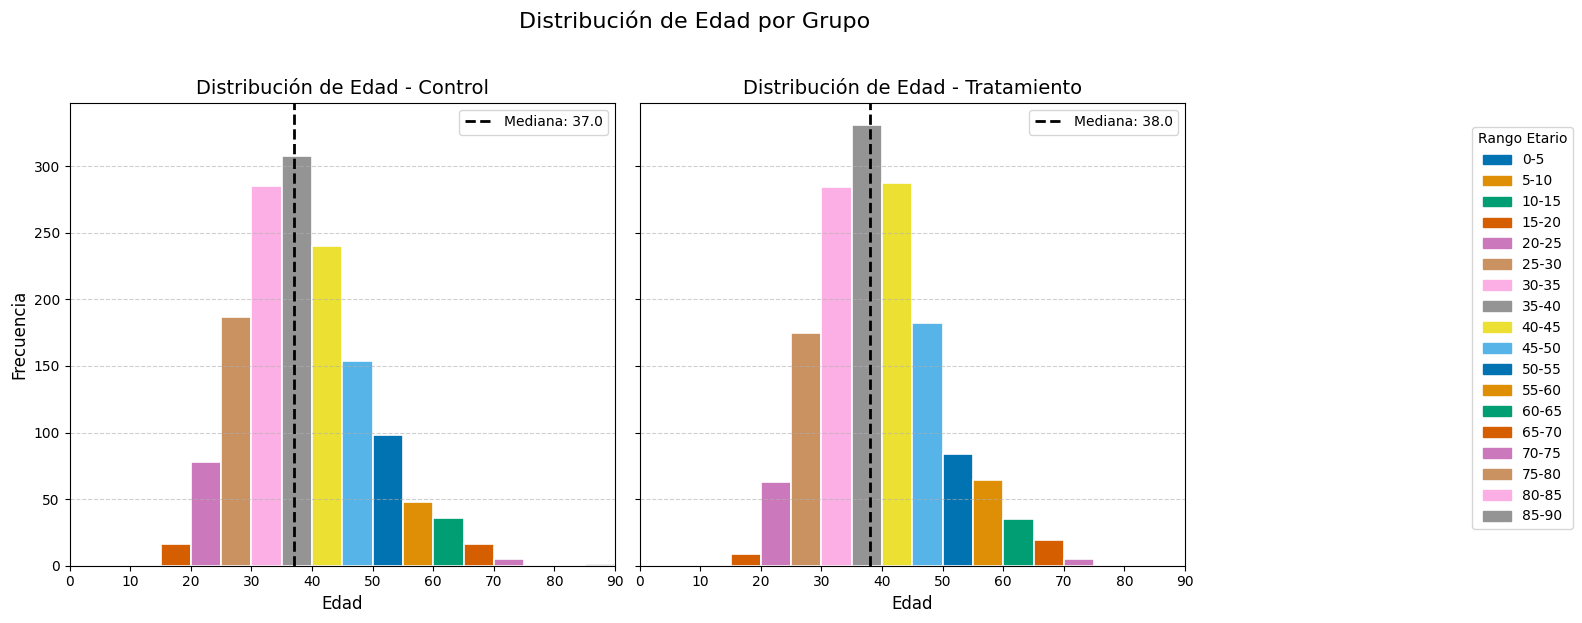

In [82]:
# Configurar bins
bins = np.arange(0, 95, 5)
bin_labels = [f'{i}-{i+5}' for i in bins[:-1]]

# Paleta categórica apta para daltónicos
palette = sns.color_palette("colorblind", len(bins) - 1)

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
grupos = ['Control', 'Tratamiento']

# Limpiar valores fuera del rango lógico (0 a 100)
formularios_estudio = formularios_estudio[(formularios_estudio['edad'] >= 0) & (formularios_estudio['edad'] <= 100)]

for i, grupo in enumerate(grupos):
    ax = axes[i]
    subset = formularios_estudio[formularios_estudio['grupo'] == grupo]
    edades = subset['edad']

    # Asignar edades a bins
    bin_indices = np.digitize(edades, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(palette) - 1)  # Evitar out of range
    
    # Contar frecuencias por bin
    counts = np.zeros(len(bins) - 1)
    for idx in bin_indices:
        counts[idx] += 1
    
    # Dibujar barras para asignar color categórico
    for j, count in enumerate(counts):
        ax.bar(bins[j], count, width=5, align='edge',
               color=palette[j], edgecolor='white', linewidth=1.2)
    
    # mediana
    mediana = np.median(edades)
    ax.axvline(mediana, color='black', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.1f}')
    
    # Estética
    ax.set_title(f'Distribución de Edad - {grupo}', fontsize=14)
    ax.set_xlabel('Edad', fontsize=12)
    ax.set_xlim(0, 90)
    ax.set_xticks(np.arange(0, 95, 10))
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    if i == 0:
        ax.set_ylabel('Frecuencia', fontsize=12)
    ax.legend(frameon=True)

# Crear leyenda de colores por bin
handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(bin_labels))]
fig.legend(handles, bin_labels, title='Rango Etario', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Título
plt.suptitle('Distribución de Edad por Grupo', fontsize=16, y=1.03)
plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.show()

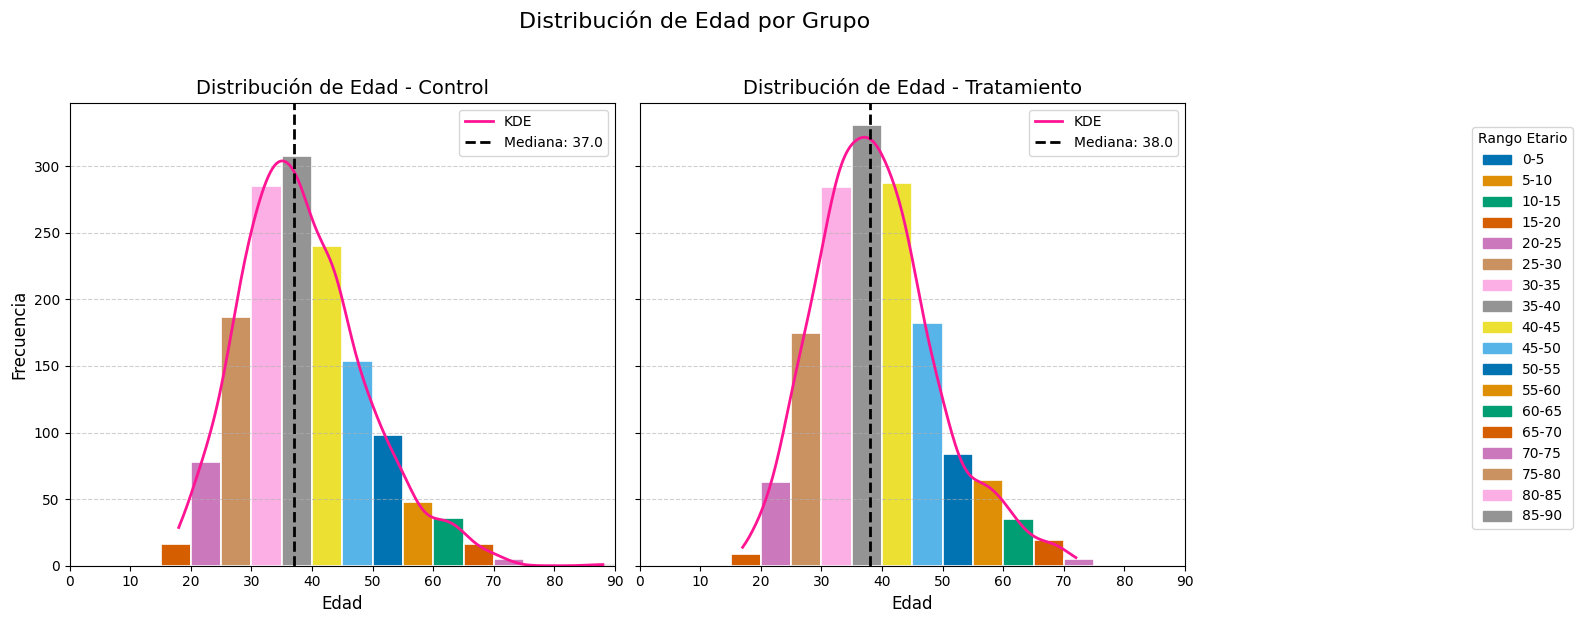

In [83]:
# Configurar bins
bins = np.arange(0, 95, 5)
bin_labels = [f'{i}-{i+5}' for i in bins[:-1]]

# Paleta categórica apta para daltónicos
palette = sns.color_palette("colorblind", len(bins) - 1)

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
grupos = ['Control', 'Tratamiento']

# Limpiar valores fuera del rango lógico (0 a 100)
formularios_estudio = formularios_estudio[(formularios_estudio['edad'] >= 0) & (formularios_estudio['edad'] <= 100)]

for i, grupo in enumerate(grupos):
    ax = axes[i]
    subset = formularios_estudio[formularios_estudio['grupo'] == grupo]
    edades = subset['edad'].dropna().astype(float).values

    
    # Asignar edades a bins
    bin_indices = np.digitize(edades, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(palette) - 1)  # Evitar out of range
    
    # Contar frecuencias por bin
    counts = np.zeros(len(bins) - 1)
    for idx in bin_indices:
        counts[idx] += 1
    

    # Dibujar barras para asignar color categórico
    for j, count in enumerate(counts):
        ax.bar(bins[j], count, width=5, align='edge',
               color=palette[j], edgecolor='white', linewidth=1.2)



    # KDE suavizada 
    kde = gaussian_kde(edades, bw_method='scott')  
    x_vals = np.linspace(min(edades), max(edades), 200)
    y_vals = kde(x_vals)

    # Escalar la KDE a frecuencia absoluta
    bin_width = bins[1] - bins[0]
    y_vals *= len(edades) * bin_width

    ax.plot(x_vals, y_vals, color='deeppink', linewidth=2, label='KDE')


    # mediana
    mediana = np.median(edades)
    ax.axvline(mediana, color='black', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.1f}')
    
    # Estética
    ax.set_title(f'Distribución de Edad - {grupo}', fontsize=14)
    ax.set_xlabel('Edad', fontsize=12)
    ax.set_xlim(0, 90)
    ax.set_xticks(np.arange(0, 95, 10))
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    if i == 0:
        ax.set_ylabel('Frecuencia', fontsize=12)
    ax.legend(frameon=True)

# Crear leyenda de colores por bin
handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(bin_labels))]
fig.legend(handles, bin_labels, title='Rango Etario', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Título
plt.suptitle('Distribución de Edad por Grupo', fontsize=16, y=1.03)
plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.show()

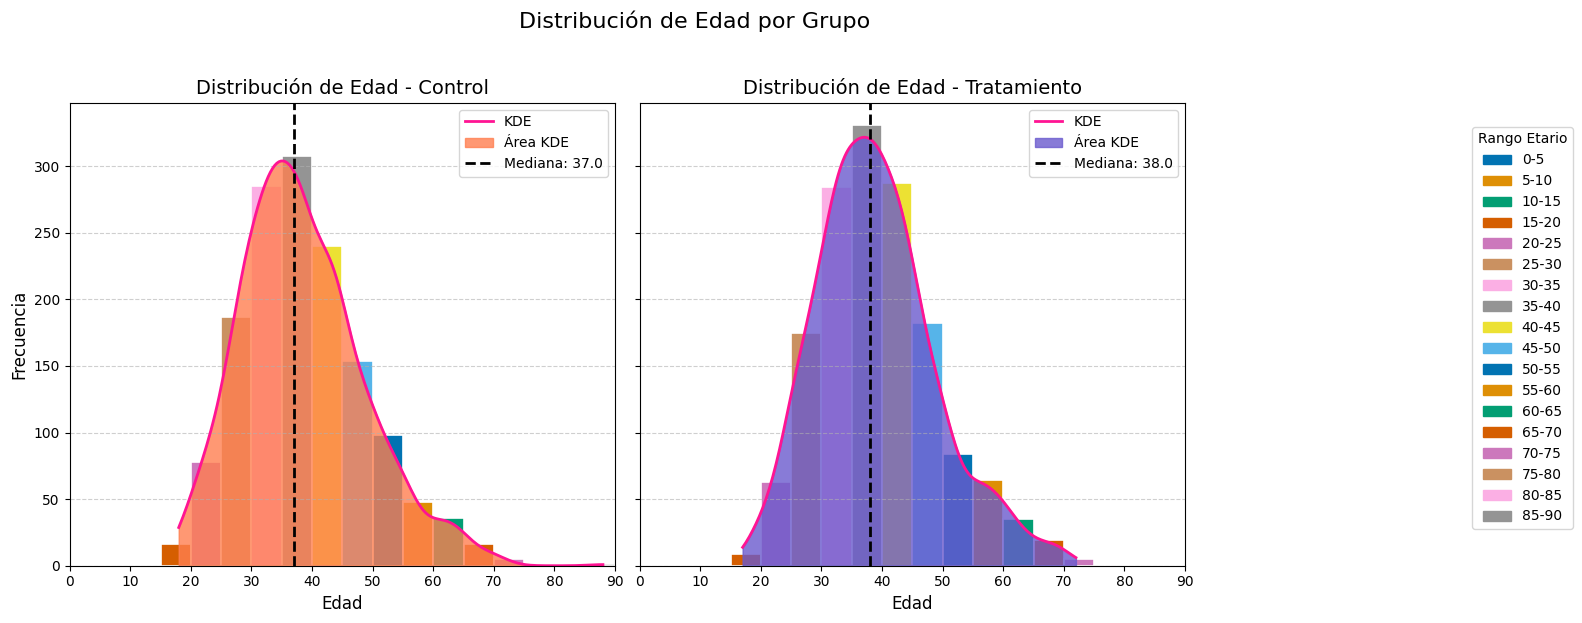

In [84]:
# Configurar bins
bins = np.arange(0, 95, 5)
bin_labels = [f'{i}-{i+5}' for i in bins[:-1]]

# Paleta categórica apta para daltónicos
palette = sns.color_palette("colorblind", len(bins) - 1)

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
grupos = ['Control', 'Tratamiento']

# Limpiar valores fuera del rango lógico (0 a 100)
formularios_estudio = formularios_estudio[(formularios_estudio['edad'] >= 0) & (formularios_estudio['edad'] <= 100)]

colores_kde = ['#FF7F50', '#6A5ACD']

for i, grupo in enumerate(grupos):
    ax = axes[i]
    subset = formularios_estudio[formularios_estudio['grupo'] == grupo]
    edades = subset['edad'].dropna().astype(float).values

         
    # Asignar edades a bins
    bin_indices = np.digitize(edades, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(palette) - 1)  # Evitar out of range
    
    # Contar frecuencias por bin
    counts = np.zeros(len(bins) - 1)
    for idx in bin_indices:
        counts[idx] += 1
    
    # Dibujar barras para asignar color categórico
    for j, count in enumerate(counts):
        ax.bar(bins[j], count, width=5, align='edge',
               color=palette[j], edgecolor='white', linewidth=1.2)


    # KDE suavizada 
    kde = gaussian_kde(edades, bw_method='scott')  
    x_vals = np.linspace(min(edades), max(edades), 200)
    y_vals = kde(x_vals)

    # Escalar la KDE a frecuencia absoluta
    bin_width = bins[1] - bins[0]
    y_vals *= len(edades) * bin_width

    ax.plot(x_vals, y_vals, color='deeppink', linewidth=2, label='KDE')

    #KDE área
    ax.fill_between(x_vals, y_vals, color=colores_kde[i], alpha=0.8, label='Área KDE')


    # mediana
    mediana = np.median(edades)
    ax.axvline(mediana, color='black', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.1f}')
    
    # Estética
    ax.set_title(f'Distribución de Edad - {grupo}', fontsize=14)
    ax.set_xlabel('Edad', fontsize=12)
    ax.set_xlim(0, 90)
    ax.set_xticks(np.arange(0, 95, 10))
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    if i == 0:
        ax.set_ylabel('Frecuencia', fontsize=12)
    ax.legend(frameon=True)

# Crear leyenda de colores por bin
handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(bin_labels))]
fig.legend(handles, bin_labels, title='Rango Etario', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Título
plt.suptitle('Distribución de Edad por Grupo', fontsize=16, y=1.03)
plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.show()

In [85]:
# mostrar plot de áreas KDE superpuestas

## ETAPA 6 : MUESTRAS ALEATORIAS SIMPLES (ingreso anual hogar)

In [86]:
mas_control['ingreso_anual_hogar']

250021    9000000
249353    2750000
250430    2500000
249236    2090000
249389    4082953
           ...   
249831    3000000
250465    1500000
250497    4345011
250146    2158000
249716    2670000
Name: ingreso_anual_hogar, Length: 1000, dtype: object

In [87]:
# Función para obtener una muestra bootstrap
def obtener_muestra_bootstrap(df_sample: pd.DataFrame, column_df_sample: str, random_state: int = 42) -> np.ndarray:
    np.random.seed(random_state)
    return np.random.choice(df_sample[column_df_sample], size=len(df_sample), replace=True)


In [88]:
muestra_boots_c = obtener_muestra_bootstrap(mas_control, 'ingreso_anual_hogar')

In [89]:
type(muestra_boots_c)

numpy.ndarray

In [90]:
muestra_boots_c

array([700000, 10000000, 800000, 3599138, 6400000, 10000, 3275979,
       2097380, 3000000, 10000000, 300000, 3000000, 5070590, 2445487,
       2500000, 1300000, 1420000, 7409986, 300000, 80000, 2000000,
       10000000, 5000000, 20000000, 1300000, 1100000, 1200000, 1000000,
       3352583, 66900, 850000, 10000000, 2600000, 2640000, 5800000,
       336000, 3000000, 3223722, 2400000, 5000000, 10000000, 150000,
       2922600, 1900000, 4096000, 3860000, 2000000, 1500000, 800000,
       1850000, 800000, 6500000, 5000000, 929344, 4567000, 1700000,
       980000, 80000, 500000, 300000, 1730400, 2097380, 1300000, 1400000,
       68000, 1010000, 1450000, 4200000, 5000000, 1524010, 4512279,
       6800000, 1600000, 3000000, 2000000, 10000000, 10000, 66900,
       10000000, 1730000, 1400000, 1500000, 5000000, 250000, 3600000,
       2210000, 1000000, 10000000, 7409986, 1010000, 2750000, 2900000,
       2112000, 1000000, 76, 2280000, 3500000, 10000000, 5000000, 1500000,
       5900000, 3913706, 

In [91]:
muestra_boots_t = obtener_muestra_bootstrap(mas_tratamiento, 'ingreso_anual_hogar')

In [92]:
# Función que calcula la media de una lista de datos obtenido por bootstrapping
def calcular_media_bootstrap(bootstrap_samples: np.ndarray) -> float:
    return np.mean(bootstrap_samples, axis=0)

In [93]:
# Calcular la media de las muestras bootstrap del grupo control
media_control_iah = calcular_media_bootstrap(muestra_boots_c)

In [94]:
# Calcular la media de las muestras bootstrap del grupo tratamiento
media_tratamiento_iah = calcular_media_bootstrap(muestra_boots_t)


In [95]:
media_tratamiento_iah

np.float64(2236188.265)

In [96]:
#Calcular la media poblacional del ingreso anual del hogar del dataset original
media_poblacional_iah = formularios_estudio['ingreso_anual_hogar'].mean()
media_poblacional_iah  

np.float64(2648588.3485049834)

### *Coeficiente de representatividad de la muestra en grupo control y en grupo tratamiento*

In [97]:
# Error absoluto de la media del grupo control y la población
error_absoluto_c = abs(media_control_iah - media_poblacional_iah)

In [98]:
# Error relativo de la media del grupo control y la población
error_relativo_c = error_absoluto_c / media_poblacional_iah
error_relativo_c

np.float64(0.10173286635769921)

In [99]:
# Error absoluto de la media del grupo tratamiento y la población
error_absoluto_t = abs(media_tratamiento_iah - media_poblacional_iah)

In [100]:
# Error relativo de la media del grupo tratamiento y la población
error_relativo_t = error_absoluto_t / media_poblacional_iah
error_relativo_t

np.float64(0.15570561719708753)

In [101]:
df_coef_repr_iah = pd.DataFrame([media_control_iah, media_tratamiento_iah])
df_coef_repr_iah.columns = ['Coeficiente de representatividad por grupo(iah)']
df_coef_repr_iah

,Coeficiente de representatividad por grupo(iah)
0,2918036.833
1,2236188.265


In [102]:
# Asignar nombres a los grupos de muestreo
df_coef_repr_iah.index = ['Control', 'Tratamiento']

In [103]:
df_coef_repr_iah

,Coeficiente de representatividad por grupo(iah)
Control,2918036.833
Tratamiento,2236188.265


## *Calculamos la mediana de la muestra poblacional y de las muestras del grupo control y del grupo tratamiento sobre el parámetro 'ingreso_anual_hogar'*

In [104]:
# Calcular la mediana del ingreso anual del hogar para el grupo control
median_control_iah = mas_control['ingreso_anual_hogar'].median()
median_control_iah

np.float64(2100000.0)

In [105]:
# Calcular la mediana del ingreso anual del hogar para el grupo tratamiento
median_tratamiento_iah = mas_tratamiento['ingreso_anual_hogar'].median()
median_tratamiento_iah

np.float64(1500000.0)

In [106]:
# Calcular la mediana del ingreso anual del hogar para la población
median_poblacional_iah = formularios_estudio['ingreso_anual_hogar'].median()
median_poblacional_iah

np.float64(1944394.5)

## *Buscamos las mejores muestras para cada grupo (control/tratamiento) -se hace sobre una distribución de datos    -*

Ordena por menor error (ev_med_ingreso)
Selecciona solo la mejor muestra (n=1)
Sin empates (with_ties = FALSE)

In [107]:
muestra_boots_c, muestra_boots_t

(array([700000, 10000000, 800000, 3599138, 6400000, 10000, 3275979,
        2097380, 3000000, 10000000, 300000, 3000000, 5070590, 2445487,
        2500000, 1300000, 1420000, 7409986, 300000, 80000, 2000000,
        10000000, 5000000, 20000000, 1300000, 1100000, 1200000, 1000000,
        3352583, 66900, 850000, 10000000, 2600000, 2640000, 5800000,
        336000, 3000000, 3223722, 2400000, 5000000, 10000000, 150000,
        2922600, 1900000, 4096000, 3860000, 2000000, 1500000, 800000,
        1850000, 800000, 6500000, 5000000, 929344, 4567000, 1700000,
        980000, 80000, 500000, 300000, 1730400, 2097380, 1300000, 1400000,
        68000, 1010000, 1450000, 4200000, 5000000, 1524010, 4512279,
        6800000, 1600000, 3000000, 2000000, 10000000, 10000, 66900,
        10000000, 1730000, 1400000, 1500000, 5000000, 250000, 3600000,
        2210000, 1000000, 10000000, 7409986, 1010000, 2750000, 2900000,
        2112000, 1000000, 76, 2280000, 3500000, 10000000, 5000000, 1500000,
        590

In [108]:
# Función para calcular submuestras bootstrap
def calcular_submuestra(muestra: np.ndarray, n_submuestras: int = 1000) -> np.ndarray:
    
    for i in range(n_submuestras):
        # Crear submuestra bootstrap (con reemplazo)
        submuestra = np.random.choice(muestra, size=len(muestra), replace=True)

    return submuestra

In [109]:
sub_control = calcular_submuestra(muestra_boots_c)


In [110]:
sub_tratamiento =calcular_submuestra(muestra_boots_t)

In [111]:
# Función para calcular la mediana y el error muestral relativo
def calcular_mediana_y_error_muestral(muestra: np.ndarray, mediana_poblacional: float) -> pd.DataFrame:
    resultados = []
    
    for i in range(len(muestra)):
        mediana_muestra = np.median(muestra)
        error_relativo = abs(mediana_muestra - mediana_poblacional) / mediana_poblacional
        
        resultados.append({
            'muestra_id': i+1,
            'mediana': mediana_muestra,
            'error_relativo': error_relativo,
            'cantidad': len(muestra)
        })
    
    return pd.DataFrame(resultados)

In [112]:
df_mediana_y_error_c = calcular_mediana_y_error_muestral(sub_control, median_poblacional_iah)


In [113]:
df_mediana_y_error_t = calcular_mediana_y_error_muestral(sub_tratamiento, median_poblacional_iah)

In [114]:
# Función para encontrar la muestra con menor error relativo
def encontrar_mejor_muestra(df_resultado):
    # Encontrar la fila con menor error relativo
    mejor_muestra = df_resultado.loc[df_resultado['error_relativo'].idxmin()]
    return mejor_muestra.to_frame().T  # Convertir Serie a DataFrame

In [115]:
menor_error_c = encontrar_mejor_muestra(df_mediana_y_error_c)


In [116]:
menor_error_c

,muestra_id,mediana,error_relativo,cantidad
0,1.0,2100000.0,0.080028,1000.0


In [117]:
menor_error_t = encontrar_mejor_muestra(df_mediana_y_error_t)


In [118]:
menor_error_t

,muestra_id,mediana,error_relativo,cantidad
0,1.0,1600000.0,0.177122,1000.0


In [119]:
df_menor_error_iah = pd.concat([menor_error_c, menor_error_t], ignore_index=True)

In [120]:
df_resumen_total

,Grupo,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_conurbano_interior_Conurbano,media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente,escenario_vulnerabilidad_social,paredes_ext_revocadas
0,Control,0.6,0.4,0.5,0.0,2943501.1,3019208.7,38.4,10.1,2.5,3.0,0.1,0.6
0,Tratamiento,0.6,0.4,0.7,0.0,2368529.3,6601576.0,39.9,27.9,2.4,2.5,0.2,0.6


In [121]:
df_final = pd.concat([df_resumen_total.reset_index(drop=True),
                      df_menor_error_iah.reset_index(drop=True)], axis=1)


In [122]:
df_final

,Grupo,media_sexo_dni_F,media_sexo_dni_M,media_relacion_de_parentezco_con_jefe_del_hogar_Soy jefa(e),media_conurbano_interior_Conurbano,media_ingreso_anual_hogar,desv_ingreso_anual_hogar,media_edad,desv_edad,media_personas_por_ambiente,desv_personas_por_ambiente,escenario_vulnerabilidad_social,paredes_ext_revocadas,muestra_id,mediana,error_relativo,cantidad
0,Control,0.6,0.4,0.5,0.0,2943501.1,3019208.7,38.4,10.1,2.5,3.0,0.1,0.6,1.0,2100000.0,0.080028,1000.0
1,Tratamiento,0.6,0.4,0.7,0.0,2368529.3,6601576.0,39.9,27.9,2.4,2.5,0.2,0.6,1.0,1600000.0,0.177122,1000.0


In [125]:
    #analisis_total es el dataframe que contiene los cálculos estadiísticos de la muestra total 
    # 6. Combinar para tabla final
    #tabla_optimizada = pd.concat([analisis_total, mejores_muestras], ignore_index=True)
    #
    #return {
    #    'resultados_totales': resultados_df,
    #    'mejores_muestras': mejores_muestras, 
    #    'tabla_optimizada': tabla_optimizada,
    #    'mediana_poblacional': mediana_poblacional
    #}


### *Visualizar la distribución muestral de las medias de ambos grupos respecto a la variable ingreso_anual_hogar*


In [ ]:
# Guardar extracción de datos respecto al ingreso anual del hogar por grupo
grupo_control_iah = formularios_estudio[formularios_estudio['grupo'] == 'Control']['ingreso_anual_hogar'] 
grupo_tratamiento_iah = formularios_estudio[formularios_estudio['grupo'] == 'Tratamiento']['ingreso_anual_hogar']

In [ ]:
#Visualizar la distribución muestral de cada grupo 
plt.figure(figsize=(10, 6))
sns.kdeplot(grupo_control_iah, 
           label='Control', fill=True, alpha=0.6)
sns.kdeplot(grupo_tratamiento_iah, 
           label='Tratamiento', fill=True, alpha=0.6)
plt.title('Distribución muestral de grupo control vs grupo tratamiento')
plt.xlabel('Valor de la métrica')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Calcular percentiles del ingreso anual del hogar para cada grupo
ic_control = np.percentile(grupo_control_iah, [2.5, 97.5])
ic_tratamiento = np.percentile(grupo_tratamiento_iah, [2.5, 97.5])

# TODO: ver lo del sigma

In [ ]:
ic_control, ic_tratamiento

In [ ]:
#visualizar el Intervalo de confianza del 95%
plt.figure(figsize=(10, 6))

# Densidades
sns.kdeplot(grupo_control_iah, label='Control', fill=True, alpha=0.4, color='blue')
sns.kdeplot(grupo_tratamiento_iah, label='Tratamiento', fill=True, alpha=0.4, color='orange')

# Intervalos de confianza
plt.axvline(ic_control[0], color='blue', linestyle='--', label='IC 95% Control')
plt.axvline(ic_control[1], color='blue', linestyle='--')

plt.axvline(ic_tratamiento[0], color='orange', linestyle='--', label='IC 95% Tratamiento')
plt.axvline(ic_tratamiento[1], color='orange', linestyle='--')

# Opcional: medias
plt.axvline(grupo_control_iah.mean(), color='red', linestyle='-', linewidth=1, label='Media Control')
plt.axvline(grupo_tratamiento_iah.mean(), color='red', linestyle='-', linewidth=1, label='Media Tratamiento')

plt.title('Distribuciones con Intervalos de Confianza del 95%')
plt.xlabel('Ingreso Anual del Hogar')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 8))
sns.kdeplot(grupo_control_iah, label='Control', fill=True, alpha=0.4, color='blue')
sns.kdeplot(grupo_tratamiento_iah, label='Tratamiento', fill=True, alpha=0.4, color='orange')

# Ajustar límites del eje x para hacer zoom
percentil_5 = np.percentile(list(grupo_control_iah) + list(grupo_tratamiento_iah), 5)
percentil_95 = np.percentile(list(grupo_control_iah) + list(grupo_tratamiento_iah), 95)
plt.xlim(percentil_5, percentil_95)

plt.axvline(grupo_control_iah.mean(), color='blue', linestyle='--', label='Media Control')
plt.axvline(grupo_tratamiento_iah.mean(), color='orange', linestyle='--', label='Media Tratamiento')
plt.title('Distribuciones (Zoom al 90% central de los datos)')
plt.legend()
plt.show()

### ¿El IC incluye el '0'?

Recordar que si el IC: [2.5, 7.8] es significativo, hay diferencia.

El análisis de bootstrap de 10,000 muestras reveló una diferencia de medianas entre tratamiento y control con un intervalo de confianza del 95% entre 2.5 y 7.8. Como el IC no incluye al 0, concluimos que el tratamiento tuvo un efecto estadísticamente significativo (porque los IC no se solapan) y positivo (porque movió la métrica en la dirección deseada). Esta diferencia sugiere que la intervención fue efectiva para mejorar el resultado medido. 

### *Calcular el Intervalo de Confianza de la Diferencia de Medias sobre ingreso anual hogar*

In [ ]:
# Crear las muestras bootstrap
n_bootstrap = 10000
dif_bootstrap = []

In [ ]:
# Realizar el bootstrap sobre el parámetro ingreso anual hogar de cada grupo
for i in range(n_bootstrap):
    # Muestra bootstrap del grupo control
    muestra_control_iah = np.random.choice(grupo_control_iah, size=len(grupo_control_iah), replace=True)
    # Muestra bootstrap del grupo tratamiento
    muestra_tratamiento_iah = np.random.choice(grupo_tratamiento_iah, size=len(grupo_tratamiento_iah), replace=True)

    # Calcular diferencia de medias para esta muestra
    diferencia = np.mean(muestra_tratamiento_iah) - np.mean(muestra_control_iah)
    dif_bootstrap.append(diferencia)

In [ ]:
# Calcular intervalo de confianza
ci_lower = np.percentile(dif_bootstrap, 2.5)
ci_upper = np.percentile(dif_bootstrap, 97.5)

print(f"IC 95% para la diferencia de medias: ({ci_lower:.2f}, {ci_upper:.2f})")

In [ ]:
print("Control - valores faltantes:")
print(df_control_clean['ingreso_anual_hogar'].isna().sum())

print("Tratamiento - valores faltantes:")
print(df_tratamiento_clean['ingreso_anual_hogar'].isna().sum())


In [ ]:
print("Control - resumen estadístico:")
print(df_control_clean['ingreso_anual_hogar'].describe())

print("\nTratamiento - resumen estadístico:")
print(df_tratamiento_clean['ingreso_anual_hogar'].describe())


In [ ]:
print(f"N control: {len(df_control_clean)}")
print(f"N tratamiento: {len(df_tratamiento_clean)}")


In [ ]:
# Unir al análisis total para comparar

#analisis_total["grupo"] = "Total"

#total_optimizado = pd.concat([analisis_total, mejores_resultados], ignore_index=True)
#total_optimizado = total_optimizado[["grupo", "cantidad", "med_ing", "ev_med_ingreso"]]

In [ ]:
# Mostrar tabla resumida

#print(total_optimizado.round(6).to_markdown(index=False))

In [ ]:
# Convertir la lista de identificadores en texto plano

In [ ]:
# Descargamos el dataframe con información de los mejores resultados
#df_mejores_resultados = pd.read_excel("mejores_resultados.xlsx")
#df_mejores_resultados.head(5)

In [ ]:
# Descargamos el archivo de la nueva encuesta a hogares
#df_nueva_encuesta = pd.read_excel("nueva_encuesta_situacion_hogar.xlsx")
#df_nueva_encuesta.head(5)